In [1]:
!python -m pip install --upgrade pip==24.0
!pip install evaluate fairseq seqeval pyngrok sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━

In [ ]:
!curl -sSL https://ngrok-agent.s3.amazonaws.com/ngrok.asc \
	| sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null \
	&& echo "deb https://ngrok-agent.s3.amazonaws.com buster main" \
	| sudo tee /etc/apt/sources.list.d/ngrok.list \
	&& sudo apt update \
	&& sudo apt install ngrok

print("ok")

In [ ]:
!ngrok config add-authtoken 2sLV4iA8j8iRMAjLywMaB7vLkiD_2nEwWQKE4rAYsFw59Mg4v

In [ ]:
from pyngrok import ngrok
from tensorboard import program

log_dir = "/kaggle/working/ner-finetuned/runs"  

tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', log_dir, '--port', '6006'])
url = tb.launch()

public_url = ngrok.connect(6006)
public_url

In [23]:
from transformers import(
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments, 
    Trainer, 
    TrainerCallback,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

from datasets import (
    Dataset,
    load_dataset, 
    load_from_disk,
    DatasetDict, 
    concatenate_datasets,
) 
import evaluate
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

_________________________________________________________________________

# Création des datasets : 
## A lancer une première fois, ou si l'on veut changer de dataset.

In [ ]:
def filter_by_length(dataset, min_len=5):
    dataset = dataset.filter(lambda example: min_len <= len(example["tokens"]))
    return dataset


In [ ]:
ds_emea = load_dataset('DrBenchmark/QUAERO', 'emea', trust_remote_code=True)
ds_emea = filter_by_length(ds_emea)
ds_emea 

In [ ]:
ds_medline = load_dataset('DrBenchmark/QUAERO', 'medline', trust_remote_code=True)
ds_medline = filter_by_length(ds_medline)
ds_medline

In [ ]:
# Autre datasets ?


In [ ]:
# Vérification des labels
label_list_emea = ds_emea["train"].features["ner_tags"].feature.names
label_list_medline = ds_medline["train"].features["ner_tags"].feature.names

label_list_emea == label_list_medline

In [ ]:
def process_dataset(dataset_original, *additional_datasets, test_ratio=0.1, seed=42):
    """
    Fusionne un ou plusieurs DatasetDict/Dataset en un seul, mélange les données et les re-sépare en train/val/test.

    :param dataset_original: Un DatasetDict ou un Dataset contenant les données de base.
    :param additional_datasets: Autres DatasetDict/Dataset à fusionner avec dataset_original.
    :param test_ratio: Proportion des données pour le test (par défaut 10%).
    :param seed: Graine aléatoire pour le mélange et le split (par défaut 42).
    :return: Le Dataset original avec un split choisi (mais ratio test = ratio validation), et un DatasetDict plus gros avec "train", "validation" et le même "test" que le DatasetDict original.
    """

    assert 0 < test_ratio < 0.5, "test_ratio doit être dans l'intervalle (0, 0.5) pour un split valide."

    # Fusionner dataset_original s'il s'agit d'un DatasetDict
    if isinstance(dataset_original, DatasetDict):
        dataset_fusionned = concatenate_datasets([dataset_original[split] for split in dataset_original.keys()])
    else:
        dataset_fusionned = dataset_original  # Si c'est déjà un Dataset

    dataset_fusionned = dataset_fusionned.shuffle(seed=seed)

    # Séparer en train (val + test)
    split_train_valtest_base = dataset_fusionned.train_test_split(test_size=2 * test_ratio, seed=seed)
    split_val_test_base = split_train_valtest_base["test"].train_test_split(test_size=0.5, seed=seed)

    # Fusionner les datasets additionnels avec le train original
    datasets_to_merge = [split_train_valtest_base["train"], split_val_test_base["train"]]

    for dataset in additional_datasets:
        if isinstance(dataset, DatasetDict):
            dataset = concatenate_datasets([dataset[split] for split in dataset.keys()])
        datasets_to_merge.append(dataset)

    dataset_rest = concatenate_datasets(datasets_to_merge).shuffle(seed=seed)

    # Calcul du ratio de validation pour garder la même proportion que dans dataset_base
    val_ratio = len(split_val_test_base["test"]) / len(dataset_rest)

    # Séparer en train et validation
    split_train_val = dataset_rest.train_test_split(test_size=val_ratio, seed=seed)

    # Créer le DatasetDict final à partir de l'original
    dataset_base = DatasetDict({
        "train": split_train_valtest_base["train"],
        "validation": split_val_test_base["train"],
        "test": split_val_test_base["test"],
    })

    # Créer le DatasetDict final de la fusion
    dataset_full = DatasetDict({
        "train": split_train_val["train"],
        "validation": split_train_val["test"],
        "test": split_val_test_base["test"],
    })

    return dataset_base, dataset_full



In [ ]:
ds_fusionned = process_dataset(ds_emea,ds_medline)
print(ds_fusionned)

ds_emea = process_dataset(ds_emea)
print(ds_emea)

ds_medline = process_dataset(ds_medline)
print(ds_medline)

# Autre dataset ?

In [ ]:
# Sauvegarde des datasets
datasets_path = "dataset/"

ds_fusionned.save_to_disk(datasets_path + "full/")
ds_emea.save_to_disk(datasets_path + "emea/" )
ds_medline.save_to_disk(datasets_path + "medline/")
# Autre dataset ?


_________________________________________________________________________

## Traitement
### A faire si le(s) dataset(s) sont déjà préparé(s) (en variable ou dans dataset/)

In [84]:
datasets_path = "dataset/"


ds_fusionned = load_from_disk(datasets_path + "fusionned")
ds_emea = load_from_disk(datasets_path + "emea" )
ds_medline = load_from_disk(datasets_path + "medline")
# Autre dataset ?

print("Dataset(s) chargé(s)")

Dataset(s) chargé(s)


In [98]:
# Choisir le dataset de travail
dataset = ds_emea

df = pd.DataFrame(dataset["train"])
print(dataset['test'])
df.describe()

Dataset({
    features: ['id', 'document_id', 'tokens', 'ner_tags'],
    num_rows: 121
})


,id,document_id,tokens,ner_tags
count,964,964,964,964
unique,574,947,947,904
top,4_19,4_0,"[Dans, des, études, d, ’, une, durée, allant, ...","[0, 0, 0, 0, 0]"
freq,3,3,4,8


In [43]:
#label_list = dataset['train'].features['ner_tags'].feature.names
num_labels = len(label_list)
id2label = {i: tag for i, tag in enumerate(label_list)}
label2id = {tag: i for i, tag in enumerate(label_list)}
print(num_labels)

21


In [86]:
ner_tags = [label_list[tag] for tags in dataset["test"]["ner_tags"] for tag in tags]
tag_counts = pd.Series(ner_tags).value_counts()
tag_counts


O         3116
B-CHEM     206
B-DISO     179
I-DISO     142
B-PROC      89
B-LIVB      86
I-CHEM      40
I-PROC      31
B-ANAT      28
B-PHYS      26
I-LIVB      12
B-DEVI      11
B-OBJC      10
I-PHYS       8
B-GEOG       6
I-ANAT       5
B-PHEN       5
I-DEVI       4
I-GEOG       1
Name: count, dtype: int64

In [58]:
def remove_tokens_with_O(dataset_dict: DatasetDict, threshold: float = 0.9) -> DatasetDict:
    """
    Supprime les entrées où le pourcentage de 'O' (0) dans ner_tags dépasse un certain seuil.

    :param dataset_dict: DatasetDict contenant les datasets train, validation, test.
    :param threshold: Pourcentage maximal de 'O' pour retirer la ligne (ex: 0.9 pour 90%).
    :return: DatasetDict filtré.
    """
    
    def filter_function(example):
        ner_tags = example["ner_tags"]
        return (sum(tag == 0 for tag in ner_tags) / len(ner_tags)) < threshold

    # Appliquer le filtrage sur chaque split
    filtered_datasets = {split: dataset.filter(filter_function) for split, dataset in dataset_dict.items()}
    
    return DatasetDict(filtered_datasets)


In [ ]:
# Exemple d'utilisation :
threshold =  0.90 # thresholdx100 % des labels doivent être "O"

dataset_clean = remove_tokens_with_O(dataset, threshold=threshold)
# print(df_cleaned)

# Données censées être enlevées :
result_mostly_O = df[df['ner_tags'].apply(lambda x: sum(tag == 0 for tag in x) / len(x) >= threshold)]
# print(result_mostly_O)

# Résultat : 
df_clean = pd.DataFrame(dataset_clean["train"])

len(df_clean) + len(result_mostly_O) == len(df) 

In [ ]:
ner_tags = [label_list[tag] for tags in dataset_clean["validation"]["ner_tags"] for tag in tags]
tag_counts = pd.Series(ner_tags).value_counts()
print(tag_counts, len(tag_counts))

## Entrainement
### On utilisera les données filtrées ou pas, pour comparer

In [26]:
model_path = "PantagrueLLM/jargon-biomed"
dataset_path = "./dataset/emea"

In [77]:
def run_model(model_path, dataset_path, threshold=False) :
    global label_list

    
    model_name = model_path.split("/")[1]
    dataset_name = dataset_path.split("/")[2]

    dataset = load_from_disk(dataset_path)
    
    if threshold :
        dataset_path, dataset_name, = dataset_path +f"_{threshold}", dataset_name +f"_{threshold}"
        dataset = remove_tokens_with_O(dataset, threshold)
        dataset.save_to_disk(dataset_path)


    label_list = dataset['train'].features['ner_tags'].feature.names
    num_labels = len(label_list)
    id2label = {i: tag for i, tag in enumerate(label_list)}
    label2id = {tag: i for i, tag in enumerate(label_list)}


    
    # --- Charger le tokenizer ---   
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # --- Tokenisation et alignement des labels ---
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)
        labels = []
        for i, label in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            label_ids = []
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)  # Ignorer ces tokens
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])  # Prendre le label du mot
                else:
                    label_ids.append(-100)  # Sous-tokens
                previous_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    
    NUM_CPU = os.cpu_count() 
    tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, num_proc = NUM_CPU)


    # --- Initialiser le modèle ---
    model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    )


    early_stopping = EarlyStoppingCallback(
       early_stopping_patience=3,  
       early_stopping_threshold=0.0  
    )
    
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    
    training_args = TrainingArguments(
        output_dir= f"./{model_name}/{dataset_name}",
        logging_dir= "./logs",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=65,
        weight_decay=0.01,
        warmup_steps=50,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        fp16=True,
        save_safetensors=False,
        save_total_limit=1,
        greater_is_better=True,
        report_to=["tensorboard"]
    )
    
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[epoch_tracker] #early_stopping
    )

    return(trainer, model)
        
    

#### Tokenisation 

In [55]:
seqeval = evaluate.load("seqeval")

class EpochTrackerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_counter = 0  # Initialisation du compteur

    def on_epoch_end(self, args, state, control, **kwargs):
        self.epoch_counter = state.epoch  # Met à jour avec l'époque actuelle

# Initialiser l'objet EpochTrackerCallback
epoch_tracker = EpochTrackerCallback()

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    # Aplatir les listes
    true_labels_flat = sum(true_labels, [])
    pred_labels_flat = sum(true_predictions, [])
    
    # Rapport détaillé des métriques
    report = classification_report(true_labels_flat, pred_labels_flat, labels=label_list, output_dict=True, zero_division=0)

    # Affichage du Micro-F1 toutes les 5 époques
    if int(epoch_tracker.epoch_counter) % 5 == 0:
        micro_f1_per_label = {label: report[label]["f1-score"] for label in label_list if label in report}
        print(f"\n[Epoch {int(epoch_tracker.epoch_counter)}] Micro-F1 Scores par label :")
        for label, f1 in micro_f1_per_label.items():
            print(f"{label}: {f1:.4f}")

    # Retourner les métriques
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],  # F1 global
        "accuracy": results["overall_accuracy"],
    }

In [78]:
trainer, model = run_model(model_path,dataset_path)

The repository for PantagrueLLM/jargon-biomed contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/PantagrueLLM/jargon-biomed.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Some weights of JargonForTokenClassification were not initialized from the model checkpoint at PantagrueLLM/jargon-biomed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
# --- Vérifier l'existence d'un checkpoint ---
model_checkpoint = None
if os.path.isdir(trainer.args.output_dir) and any("checkpoint" in d for d in os.listdir(trainer.args.output_dir)):
    model_checkpoint = max(
        [d for d in os.listdir(trainer.args.output_dir) if "checkpoint" in d],
        key=lambda x: int(x.split("-")[-1]),
    )
    model_checkpoint = os.path.join(trainer.args.output_dir, model_checkpoint)
    print(f"Reprise à partir du checkpoint {model_checkpoint}")
else :
    print("Il n'y a pas encore de checkpoint.")

Reprise à partir du checkpoint ./jargon-biomed/emea/checkpoint-434


In [71]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 3.166151523590088,
 'eval_precision': 0.005966910767561703,
 'eval_recall': 0.03193033381712627,
 'eval_f1': 0.010054844606946984,
 'eval_accuracy': 0.0203579418344519,
 'eval_runtime': 1.4861,
 'eval_samples_per_second': 81.423,
 'eval_steps_per_second': 2.692}

In [82]:
trainer.train(resume_from_checkpoint = model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
15,0.009800,0.275315,0.785714,0.830189,0.807339,0.947875
16,0.009800,0.281072,0.836795,0.818578,0.827586,0.950559
17,0.010800,0.348034,0.818040,0.763425,0.789790,0.941387
18,0.007800,0.326477,0.811012,0.791001,0.800882,0.947204
19,0.007800,0.289587,0.840774,0.820029,0.830272,0.951230
20,0.006000,0.310017,0.797753,0.824383,0.810849,0.948098
21,0.007200,0.304294,0.854962,0.812772,0.833333,0.952796
22,0.007200,0.300302,0.821637,0.815675,0.818645,0.950783
23,0.004800,0.318927,0.822157,0.818578,0.820364,0.949441
24,0.004800,0.339236,0.830882,0.820029,0.825420,0.949441



[Epoch 15] Micro-F1 Scores par label :
O: 0.9753
B-LIVB: 0.9730
I-LIVB: 0.6667
B-PROC: 0.8670
I-PROC: 0.7111
B-ANAT: 0.6486
I-ANAT: 0.4000
B-DEVI: 0.8125
I-DEVI: 0.7500
B-CHEM: 0.9183
I-CHEM: 0.8382
B-GEOG: 0.7619
I-GEOG: 0.6667
B-PHYS: 0.7027
I-PHYS: 0.3158
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.8958
I-DISO: 0.8108
B-OBJC: 0.7170
I-OBJC: 0.6667


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/di


[Epoch 20] Micro-F1 Scores par label :
O: 0.9750
B-LIVB: 0.9664
I-LIVB: 0.6667
B-PROC: 0.8646
I-PROC: 0.7253
B-ANAT: 0.6875
I-ANAT: 0.5000
B-DEVI: 0.7368
I-DEVI: 0.7500
B-CHEM: 0.9264
I-CHEM: 0.8780
B-GEOG: 0.7619
I-GEOG: 0.6667
B-PHYS: 0.6829
I-PHYS: 0.4000
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.8912
I-DISO: 0.8203
B-OBJC: 0.7143
I-OBJC: 0.2500


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/di


[Epoch 25] Micro-F1 Scores par label :
O: 0.9765
B-LIVB: 0.9396
I-LIVB: 0.6667
B-PROC: 0.8663
I-PROC: 0.7126
B-ANAT: 0.6857
I-ANAT: 0.3333
B-DEVI: 0.8889
I-DEVI: 0.5714
B-CHEM: 0.9391
I-CHEM: 0.8759
B-GEOG: 0.7368
I-GEOG: 0.6667
B-PHYS: 0.7123
I-PHYS: 0.3529
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9151
I-DISO: 0.7867
B-OBJC: 0.6818
I-OBJC: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/di


[Epoch 30] Micro-F1 Scores par label :
O: 0.9752
B-LIVB: 0.9536
I-LIVB: 0.6667
B-PROC: 0.8482
I-PROC: 0.7059
B-ANAT: 0.6667
I-ANAT: 0.4000
B-DEVI: 0.8235
I-DEVI: 0.7500
B-CHEM: 0.9231
I-CHEM: 0.8841
B-GEOG: 0.8000
I-GEOG: 0.6667
B-PHYS: 0.6944
I-PHYS: 0.3333
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.8858
I-DISO: 0.8198
B-OBJC: 0.7347
I-OBJC: 0.4000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/di


[Epoch 35] Micro-F1 Scores par label :
O: 0.9767
B-LIVB: 0.9530
I-LIVB: 0.7500
B-PROC: 0.8571
I-PROC: 0.7143
B-ANAT: 0.7500
I-ANAT: 0.6667
B-DEVI: 0.8500
I-DEVI: 0.7500
B-CHEM: 0.9325
I-CHEM: 0.8971
B-GEOG: 0.8462
I-GEOG: 0.6667
B-PHYS: 0.7073
I-PHYS: 0.2500
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.8834
I-DISO: 0.8145
B-OBJC: 0.7917
I-OBJC: 0.4000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[Epoch 40] Micro-F1 Scores par label :
O: 0.9780
B-LIVB: 0.9600
I-LIVB: 0.4444
B-PROC: 0.8763
I-PROC: 0.6957
B-ANAT: 0.6667
I-ANAT: 0.5000
B-DEVI: 0.8947
I-DEVI: 0.7500
B-CHEM: 0.9414
I-CHEM: 0.8633
B-GEOG: 0.8696
I-GEOG: 0.6667
B-PHYS: 0.7297
I-PHYS: 0.3529
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9097
I-DISO: 0.8195
B-OBJC: 0.7500
I-OBJC: 0.5000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[Epoch 45] Micro-F1 Scores par label :
O: 0.9777
B-LIVB: 0.9664
I-LIVB: 0.6667
B-PROC: 0.8718
I-PROC: 0.7333
B-ANAT: 0.7222
I-ANAT: 0.3333
B-DEVI: 0.8333
I-DEVI: 0.7500
B-CHEM: 0.9467
I-CHEM: 0.8939
B-GEOG: 0.9091
I-GEOG: 1.0000
B-PHYS: 0.7105
I-PHYS: 0.3333
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9155
I-DISO: 0.8057
B-OBJC: 0.7308
I-OBJC: 0.2857


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t


[Epoch 50] Micro-F1 Scores par label :
O: 0.9771
B-LIVB: 0.9664
I-LIVB: 0.6000
B-PROC: 0.8615
I-PROC: 0.7442
B-ANAT: 0.7222
I-ANAT: 0.5714
B-DEVI: 0.8571
I-DEVI: 0.7500
B-CHEM: 0.9391
I-CHEM: 0.8824
B-GEOG: 0.8696
I-GEOG: 0.6667
B-PHYS: 0.7200
I-PHYS: 0.3529
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9046
I-DISO: 0.8019
B-OBJC: 0.7308
I-OBJC: 0.4000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[Epoch 55] Micro-F1 Scores par label :
O: 0.9766
B-LIVB: 0.9664
I-LIVB: 0.6667
B-PROC: 0.8673
I-PROC: 0.7045
B-ANAT: 0.6842
I-ANAT: 0.6667
B-DEVI: 0.8235
I-DEVI: 0.7500
B-CHEM: 0.9389
I-CHEM: 0.9008
B-GEOG: 0.8571
I-GEOG: 1.0000
B-PHYS: 0.7200
I-PHYS: 0.3529
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9104
I-DISO: 0.8131
B-OBJC: 0.6792
I-OBJC: 0.2857


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t


[Epoch 65] Micro-F1 Scores par label :
O: 0.9771
B-LIVB: 0.9664
I-LIVB: 0.6667
B-PROC: 0.8586
I-PROC: 0.7126
B-ANAT: 0.6842
I-ANAT: 0.6667
B-DEVI: 0.7879
I-DEVI: 0.7500
B-CHEM: 0.9428
I-CHEM: 0.8955
B-GEOG: 0.8571
I-GEOG: 1.0000
B-PHYS: 0.6923
I-PHYS: 0.3529
B-PHEN: 0.0000
I-PHEN: 0.0000
B-DISO: 0.9143
I-DISO: 0.8019
B-OBJC: 0.6923
I-OBJC: 0.4000


TrainOutput(global_step=2015, training_loss=0.0023591186453775495, metrics={'train_runtime': 2380.5422, 'train_samples_per_second': 26.322, 'train_steps_per_second': 0.846, 'total_flos': 1.5799818609605112e+16, 'train_loss': 0.0023591186453775495, 'epoch': 65.0})

In [39]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.2519158124923706,
 'eval_precision': 0.814868804664723,
 'eval_recall': 0.8113207547169812,
 'eval_f1': 0.8130909090909091,
 'eval_accuracy': 0.9463087248322147,
 'eval_runtime': 1.5362,
 'eval_samples_per_second': 78.763,
 'eval_steps_per_second': 2.604,
 'epoch': 13.0}

In [101]:
# --- Charger le tokenizer ---   
tokenizer = AutoTokenizer.from_pretrained(model_path)

# --- Tokenisation et alignement des labels ---
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorer ces tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Prendre le label du mot
            else:
                label_ids.append(-100)  # Sous-tokens
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


dataset = dataset.map(tokenize_and_align_labels, batched=True)

results = trainer.evaluate(dataset["test"])
print(results)


Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[Epoch 65] Micro-F1 Scores par label :
O: 0.9810
B-LIVB: 0.9704
I-LIVB: 0.9600
B-PROC: 0.8750
I-PROC: 0.7451
B-ANAT: 0.7636
I-ANAT: 0.6667
B-DEVI: 0.9167
I-DEVI: 1.0000
B-CHEM: 0.9400
I-CHEM: 0.7632
B-GEOG: 1.0000
I-GEOG: 1.0000
B-PHYS: 0.6531
I-PHYS: 0.3333
B-PHEN: 0.8333
I-PHEN: 0.0000
B-DISO: 0.9178
I-DISO: 0.8602
B-OBJC: 0.5600
I-OBJC: 0.0000
{'eval_loss': 0.3628017008304596, 'eval_precision': 0.848159509202454, 'eval_recall': 0.8560371517027864, 'eval_f1': 0.8520801232665639, 'eval_accuracy': 0.9590511860174782, 'eval_runtime': 2.0617, 'eval_samples_per_second': 58.689, 'eval_steps_per_second': 1.94, 'epoch': 65.0}


In [102]:
predictions = trainer.predict(dataset["test"])
logits = predictions.predictions
labels = predictions.label_ids

y_pred = np.argmax(logits, axis=2)  
y_true = labels

y_pred = np.concatenate(y_pred).flatten()
y_true = np.concatenate(y_true).flatten()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[Epoch 65] Micro-F1 Scores par label :
O: 0.9810
B-LIVB: 0.9704
I-LIVB: 0.9600
B-PROC: 0.8750
I-PROC: 0.7451
B-ANAT: 0.7636
I-ANAT: 0.6667
B-DEVI: 0.9167
I-DEVI: 1.0000
B-CHEM: 0.9400
I-CHEM: 0.7632
B-GEOG: 1.0000
I-GEOG: 1.0000
B-PHYS: 0.6531
I-PHYS: 0.3333
B-PHEN: 0.8333
I-PHEN: 0.0000
B-DISO: 0.9178
I-DISO: 0.8602
B-OBJC: 0.5600
I-OBJC: 0.0000


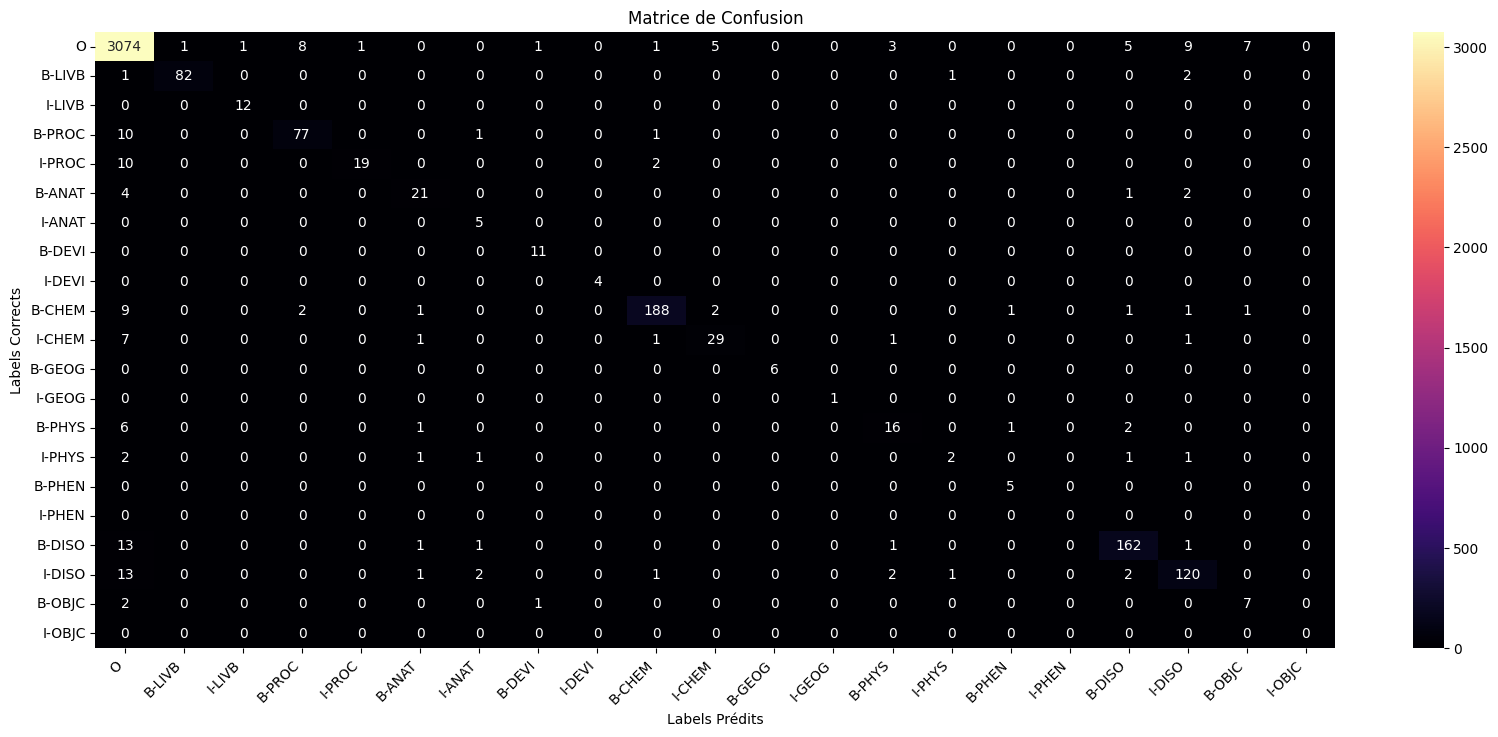

In [103]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(id2label.keys()))

plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="magma", xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))

plt.xlabel("Labels Prédits")
plt.ylabel("Labels Corrects")
plt.title("Matrice de Confusion")
plt.xticks(rotation=45, ha="right")

plt.show()


In [104]:
valid_indices = np.array(y_true) != -100

y_true_filtered = np.array(y_true)[valid_indices]
y_pred_filtered = np.array(y_pred)[valid_indices]

print("Classes dans y_true_filtered :", np.unique(y_true_filtered))
print("Classes dans y_pred_filtered :", np.unique(y_pred_filtered))
print("Nombre de classes dans id2label :", len(id2label))

unique_classes = np.unique(np.concatenate((y_true_filtered, y_pred_filtered)))
filtered_target_names = [id2label[i] for i in unique_classes]

report_dict = classification_report(
    y_true_filtered, y_pred_filtered, 
    labels=unique_classes,  # Important : ne garder que ces classes
    target_names=filtered_target_names, 
    digits=4, zero_division=0, output_dict=True
)


correct_counts = (y_true_filtered == y_pred_filtered).astype(int)
correct_per_label = {id2label[label]: sum(correct_counts[y_true_filtered == label]) for label in set(y_true_filtered)}


for label in report_dict.keys():
    if label in correct_per_label:
        report_dict[label]["correct"] = f"{correct_per_label[label]}"
        
df_report = pd.DataFrame(report_dict).transpose()
df_report

Classes dans y_true_filtered : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19]
Classes dans y_pred_filtered : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19]
Nombre de classes dans id2label : 21


,precision,recall,f1-score,support,correct
O,0.975563,0.986521,0.981012,3116,3074
B-LIVB,0.987952,0.953488,0.970414,86,82
I-LIVB,0.923077,1.0,0.96,12,12
B-PROC,0.885057,0.865169,0.875,89,77
I-PROC,0.95,0.612903,0.745098,31,19
B-ANAT,0.777778,0.75,0.763636,28,21
I-ANAT,0.5,1.0,0.666667,5,5
B-DEVI,0.846154,1.0,0.916667,11,11
I-DEVI,1.0,1.0,1.0,4,4
B-CHEM,0.969072,0.912621,0.94,206,188


In [105]:
def unify_tags(y, id2label):
    return np.array([id2label[label].replace("B-", "").replace("I-", "") for label in y])

In [106]:
report_split = classification_report(
    y_true_filtered, y_pred_filtered, 
    labels=unique_classes,  # Important : ne garder que ces classes
    target_names=filtered_target_names, 
    digits=4, zero_division=0, output_dict=True
)


y_true_unified = unify_tags(y_true_filtered, id2label)
y_pred_unified = unify_tags(y_pred_filtered, id2label)

report_unified = classification_report(y_true_unified, y_pred_unified, digits=4, zero_division=0, output_dict=True)

global_metrics = ["accuracy", "macro avg", "weighted avg"]

df_global_split = pd.DataFrame({key: report_split[key] for key in global_metrics}).transpose()
df_global_unified = pd.DataFrame({key: report_unified[key] for key in global_metrics}).transpose()

df_final = df_global_split.join(df_global_unified, lsuffix="_split", rsuffix="_unified")

df_final

,precision_split,recall_split,f1-score_split,support_split,precision_unified,recall_unified,f1-score_unified,support_unified
accuracy,0.959051,0.959051,0.959051,0.959051,0.960549,0.960549,0.960549,0.960549
macro avg,0.831777,0.848483,0.828392,4005.000000,0.832502,0.867741,0.844184,4005.000000
weighted avg,0.959279,0.959051,0.958453,4005.000000,0.960618,0.960549,0.960203,4005.000000


In [ ]:
ner_tags = [label_list[tag] for tags in df_val["ner_tags"] for tag in tags]
tag_counts = pd.Series(ner_tags).value_counts()
print(tag_counts, len(tag_counts))
ner_tags = [label_list[tag] for tags in df_train["ner_tags"] for tag in tags]
tag_counts = pd.Series(ner_tags).value_counts()
print(tag_counts, len(tag_counts))
ner_tags = [label_list[tag] for tags in df_test["ner_tags"] for tag in tags]
tag_counts = pd.Series(ner_tags).value_counts()
print(tag_counts, len(tag_counts))


In [ ]:
def plot_repartition_classes(df):
    id_label_list = df["ner_tags"].explode().unique().tolist()
    ner_tags = [tag for tags in df["ner_tags"] for tag in tags]
    label_list = [id2label[i] for i in id_label_list ]
    print(label_list)
    tag_counts = pd.Series(ner_tags).value_counts()
    
    plt.figure(figsize=(18, 6))
    sns.barplot(x=label_list, y=tag_counts, palette="Blues_r")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Labels NER")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Distribution des labels NER dans le dataset")
    plt.show()

In [ ]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

df_total = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [ ]:
plot_repartition_classes(df_val)

Changement de dataset

In [ ]:
model_90, trainer_90 = run_model(model_path,dataset_path, 90)

In [ ]:
trainer.evaluate()